## Final Project Submission

Please fill out:
* Student name: Stephan Osterburg
* Student pace: full time
* Scheduled project review date/time: 10/29/2018
* Instructor name: Rafael Carrasco 


### Import all needed libraries 

In [1]:
import os
import math
import random

import pandas as pd
import numpy as np
import json

from scipy import stats, linalg

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import missingno as msno

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# set style
sns.set_style('whitegrid')
# overriding font size and line width
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# map visualization
import folium

# don't print matching warnings
import warnings
warnings.filterwarnings('ignore') 


In [2]:
# import local functions
#
import functions as f

from importlib import reload
reload(f)

<module 'functions' from '/Users/stephanosterburg/git/learnco_projects/module_1/dsc-1-final-project-online-ds-ft-100118/functions.py'>

## Obtaining Data

###### Column Description

+ **ida** notation for a house
+ **date** Date house was sold
+ **price** Price is prediction target
+ **bedrooms** Number of Bedrooms/House
+ **bathrooms** Number of bathrooms/bedrooms
+ **sqft_living** square footage of the home
+ **sqft_lot** square footage of the lot
+ **floors** Total floors (levels) in house
+ **waterfront** House which has a view to a waterfront (should be category)
+ **view** Has been viewed
+ **condition** How good the condition is ( Overall )  (should be category)
+ **grade** overall grade given to the housing unit, based on King County grading system (should be category)
+ **sqft_above** square footage of house apart from basement
+ **sqft_basement** square footage of the basement
+ **yr_built** Built Year
+ **yr_renovated** Year when house was renovated
+ **zipcode** zip
+ **lat** Latitude coordinate
+ **long** Longitude coordinate
+ **sqft_living15** Living room area in 2015 (implies-- some renovations) This might or might not have affected the lot size area
+ **sqft_lot15** lotSize area in 2015 (implies-- some renovations)

In [3]:
# read data and read date correctly
#
kc_df = pd.read_csv("kc_house_data.csv", parse_dates = ['date'])

### Collecting basic informations about the data set

In [ ]:
kc_df.info()

In [ ]:
kc_df.dtypes

In [ ]:
kc_df.shape

In [ ]:
kc_df.head() 

### Convert

BUG -> converts all year numbers to 1970

In [ ]:
# to datetime
#
# kc_df['yr_built'] = pd.to_datetime(kc_df['yr_built']).dt.year
# kc_df['yr_renovated'] = pd.to_datetime(kc_df['yr_renovated']).dt.year

### Get a big picture overview

In [ ]:
# Correlation Matrix
kc_df.corr()

In [ ]:
abs(kc_df.corr()) > 0.7

In [ ]:
f.display_heatmap(kc_df)

Opservation:
    * there are very few correlations around 0.7 and above
    * grade seems to have goood correlations to
        - bathrooms
        - sqft_living
        - sqft_living15
        - price
    * sqft_above and sqft_living/sqft_living15 can be consulitated
    

___

# Scrubbing Data


## Cleaning Data

In [ ]:
kc_df.dtypes

In [ ]:
# Display all missing data
#
msno.matrix(kc_df)

##### Questions? 
+ Can we neglect the amount of NaN's in *waterfront* and *yr_renovated*? 
+ How about the amount of NaN under *view*?

In [4]:
# Handling Null values for view
#
kc_df.view.fillna(0, inplace=True)

In [5]:
# Handling sqft_basement
#
def calc_basement(row):
    """
    Calculate basement sqft based on difference sqft_living and sqft_above
    Deals at the same time with the '?'
    
    :param row: feature (column)
    :return: value (sqft)
    """
    return row['sqft_living'] - row['sqft_above'] if row['sqft_above'] < row['sqft_living']  else 0

kc_df.sqft_basement = kc_df.apply(calc_basement, axis = 1)

**Question:** What of the following sqft columns matter most?
    + sqft_above
    + sqft_basement
    + sqft_living
    + sqft_living15
    + sqft_lot
    + sqft_lot15
    
*Note:* sqft_living15 and sqft_lot15 are baseed on 2015 input

In [6]:
# Handling yr_renovated
# - create new column 'renovated' and 'yr_since_renovation'
# - if sqft_living15 > sqft_living set renovated
# - drop yr_renovated
#
import datetime
cur_year = datetime.datetime.now().year

def calc_years(row):
    return cur_year - row['yr_renovated'] if row['yr_renovated'] > 0 else 0

def set_renovated(row):
    return 1 if row['yr_since_renovation'] > 0 or row['sqft_living'] != row['sqft_living15'] else 0

# Set yr_renovated to int
kc_df.yr_renovated.fillna(0, inplace = True)
# now I can convert yr_renovated to int
kc_df.yr_renovated = kc_df.yr_renovated.astype('int64')

kc_df['yr_since_renovation'] = kc_df.apply(calc_years, axis = 1)
kc_df['is_renovated'] = kc_df.apply(set_renovated, axis=1)

kc_df.drop(columns=['yr_renovated'], inplace=True)

In [ ]:
msno.matrix(kc_df)

In [7]:
# Waterfront
# For future implementation
# https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/
# 
# For the time being I am setting waterfront to 'str' -> 'category' later
kc_df.waterfront = kc_df.waterfront.astype('str')

In [8]:
# Set zipcode type to string (folium)
kc_df['zipcode'] = kc_df['zipcode'].astype('str')

# Convert to int
kc_df['sqft_basement'] = pd.to_numeric(kc_df['sqft_basement'], errors='coerce')

# sort data by date and reset index
kc_df = kc_df.sort_values(by = ['date'])
kc_df = kc_df.reset_index(drop=True)

In [ ]:
msno.matrix(kc_df)

In [ ]:
kc_df.shape

In [ ]:
# Lets see what the data looks like now
#
f.display_heatmap(kc_df)

___

### Get a gerneral overview via scatter plot

In [14]:
cols = ['price', 'bedrooms', 'bathrooms', 'sqft_above', 'sqft_basement', 'sqft_living15', 'floors', 
        'sqft_lot15', 'yr_since_renovation', 'yr_built', 'view', 'condition', 'grade', 'renovated']

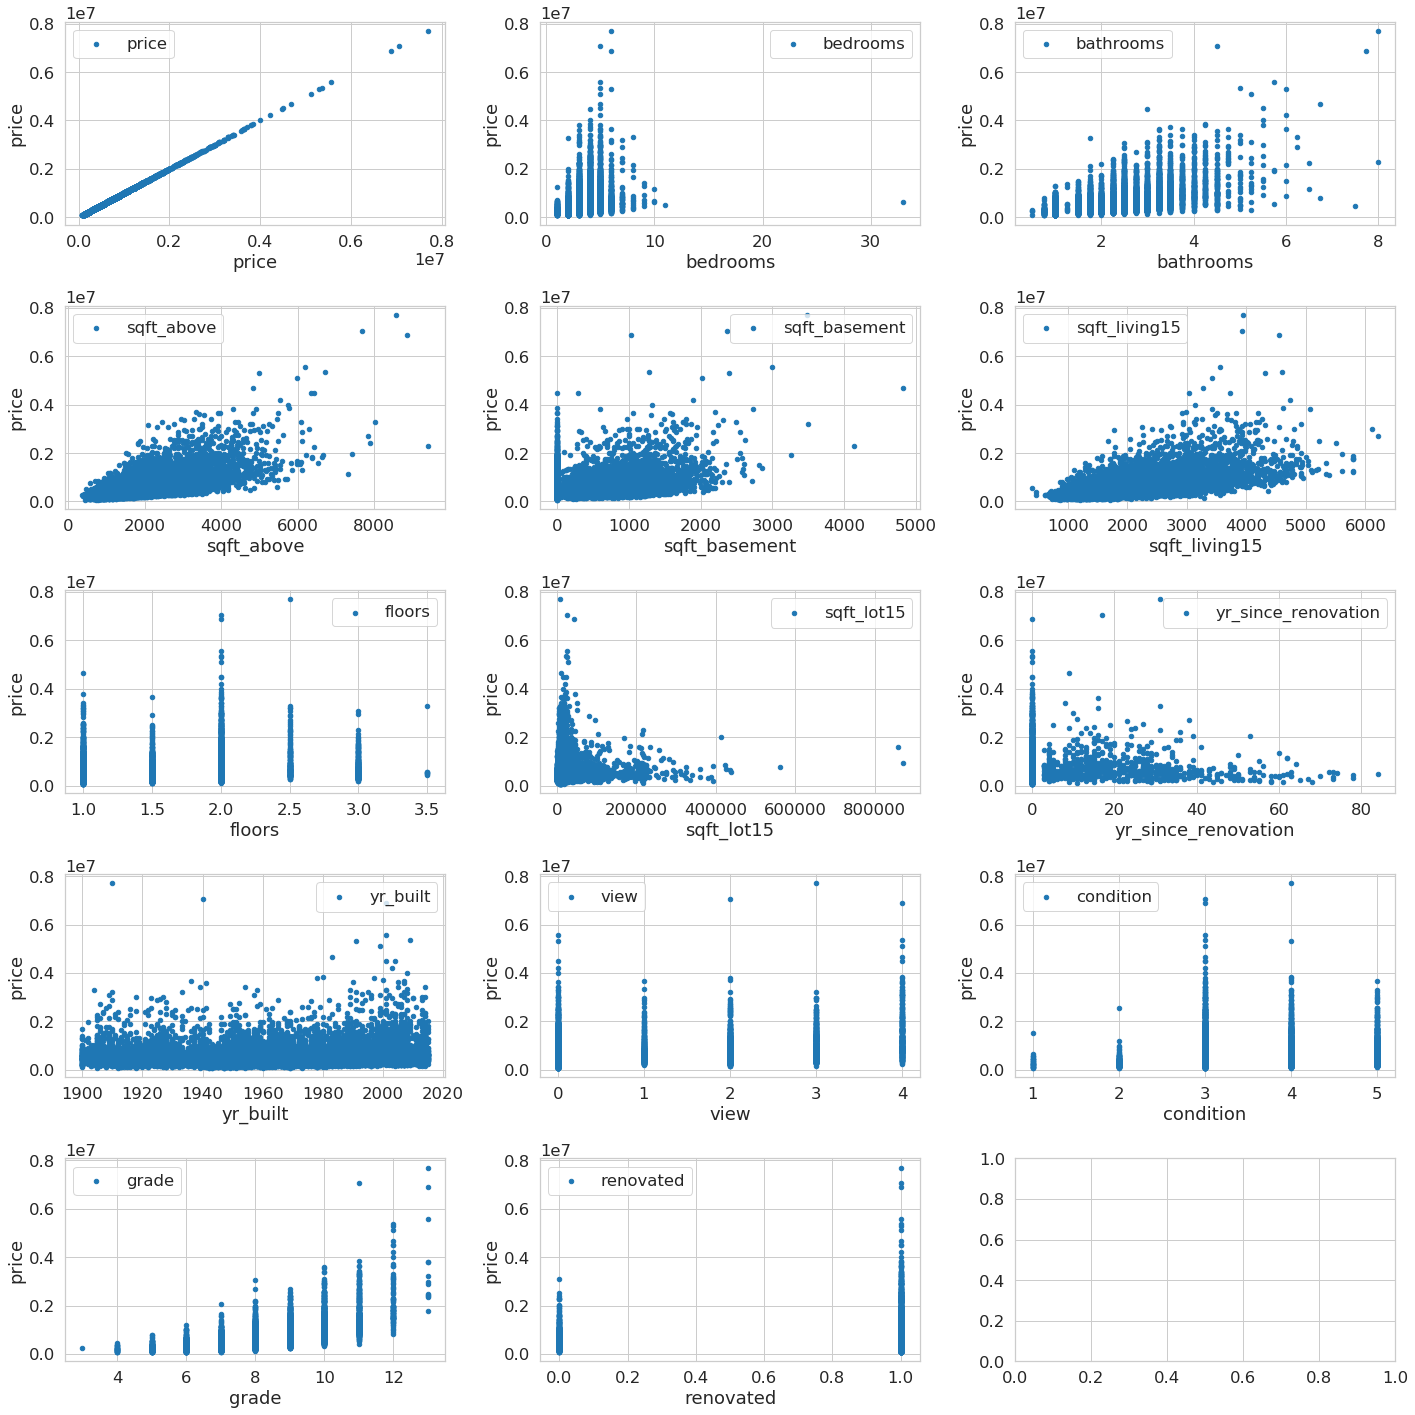

In [21]:
ncol = 3 # pick one dimension
nrow = math.floor((len(cols)+ ncol-1) / ncol) # make sure enough subplots
fig, axarr = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, 20)) # create the axes

for i in range(len(cols)): # go over a linear list of data
    ix = np.unravel_index(i, axarr.shape) # compute an appropriate index (1d or 2d)

    name = cols[i]
    kc_df.plot(kind='scatter', x=name, y='price', ax=axarr[ix], label=name) 

plt.tight_layout()
plt.show();

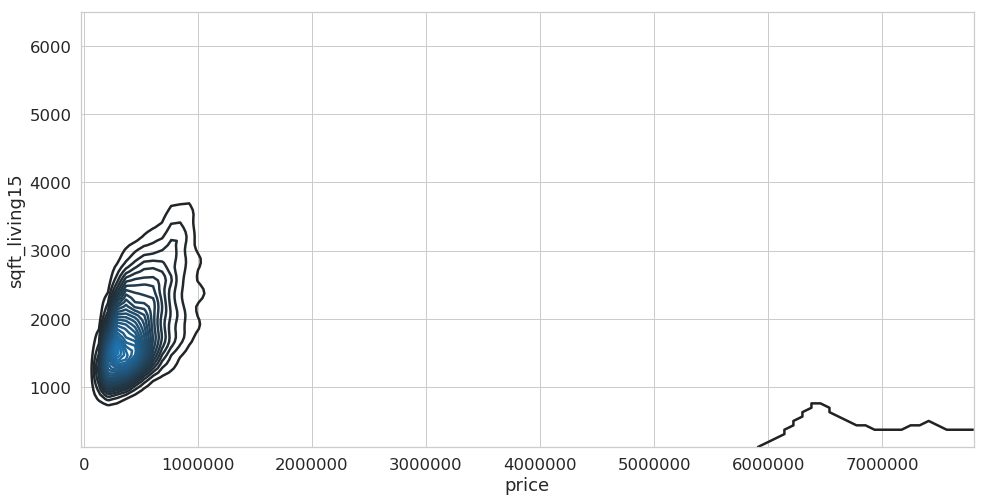

In [11]:
ax = plt.figure(figsize=(16, 8))
ax = sns.kdeplot(kc_df.price, kc_df.sqft_living15, n_levels=30)

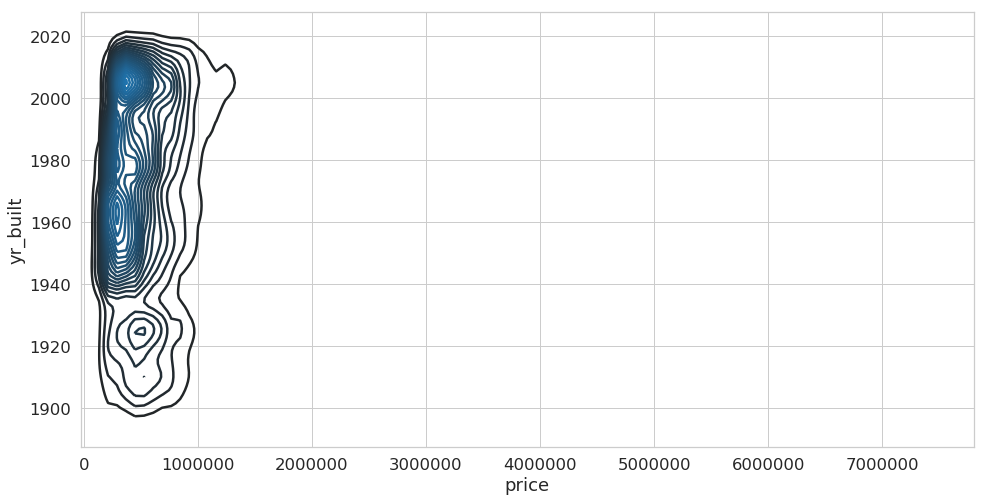

In [10]:
ax = plt.figure(figsize=(16, 8))
ax = sns.kdeplot(kc_df.price, kc_df.yr_built, n_levels=30)

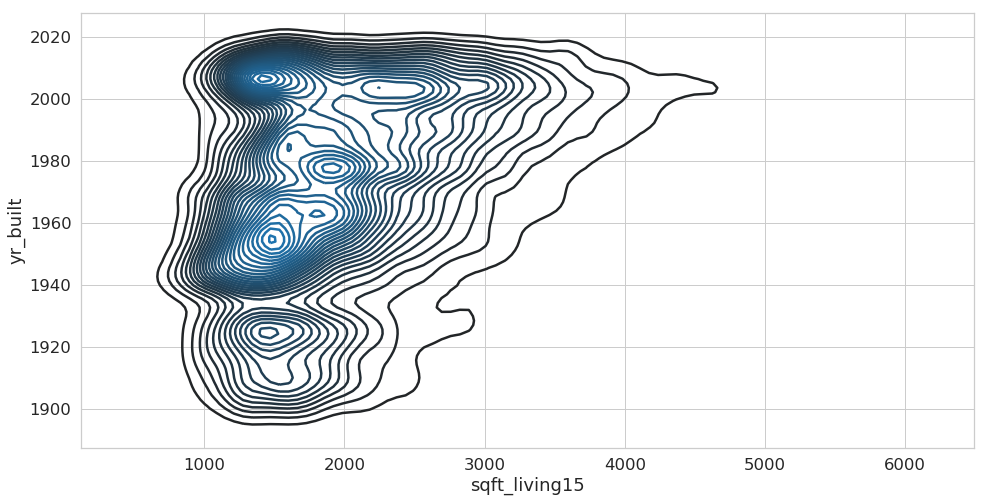

In [16]:
ax = plt.figure(figsize=(16, 8))
ax = sns.kdeplot(kc_df.sqft_living15, kc_df.yr_built, n_levels=30)

___

##### Initial  
+ yr_renovated = float, should be int
+ categories:
    - waterfront (later)
    - renovated
    - condition
    - grade
+ create new categories (maybe): 
    - upscaled (0, 1)
    - downscaled (0, 1)
+ create new column:
    - yr_since_renovation (yr_renovated -> convert to "how long ago")
    - renovated (category)
+ to be removed:
    - sqft_above, sqft_basement
    - lat, long (might be useful later for viz work)
    - id, date
+ consolidate later:
    - sqft_living, sqft_living15
    - sqft_lot, sqft_lot15

### Normalizing Data

### Categorize Data

## Subset exploration

In [ ]:
# Create subset of dataset (10%)
#
subset_df = kc_df.sample(frac=0.1)

In [ ]:
subset_df.shape

___

### Identifying Multicollinearity

In [ ]:
# Correlation Matrix
subset_df.corr()

In [ ]:
abs(subset_df.corr()) > 0.75

In [ ]:
# Checking if there might be some data loss  or so....
#
f.display_heatmap(subset_df)

___

### Investigating Continuos Variables

In [ ]:
# cont_var_df = prep_df.copy()

# # Filter out only values which are higher than 0
# prep_df['yr_renovated_actual'] = prep_df.yr_since_renovation.apply(lambda x: x if x > 0 else None)

# # Create category 'has_basement'
# prep_df['has_basement'] = data.sqft_basement.apply(lambda x: 1 if x > 0 else 0)
# prep_df['has_basement'] = cont_var_df.has_basement.astype('category', ordered = False)

# # Create category 'is_renovated'
# prep_df['is_renovated'] = data.yr_renovated.apply(lambda x: 1 if x > 0 else 0)
# prep_df['is_renovated'] = cont_var_df.is_renovated.astype('category', ordered = False)

In [ ]:
continous_vars = ['yr_built', 'sqft_basement', 'sqft_living15', 'sqft_lot', 'yr_since_renovation']

In [ ]:
f.display_jointplot(subset_df, continous_vars)

In [ ]:
f.measure_strength(subset_df, continous_vars, 'price')

### Investigate Discrete Variables

In [ ]:
discrete_vars = ['grade', 'condition', 'view', 'floors', 'bedrooms', 'bathrooms']

In [ ]:
f.display_jointplot(kc_df, discrete_vars)

In [ ]:
f.measure_strength(subset_df, discrete_vars, 'price')

In [ ]:
# Display bos-and-whisker plot showing as well outliers
#
f.display_plot(subset_df, discrete_vars, 'price')

### Relational plots

In [ ]:
g = sns.relplot(x="sqft_living15", y="price", hue="price", col="grade", 
                size="price", sizes=(5, 500), col_wrap=3, data=subset_df)

g

In [ ]:
g = sns.relplot(x="sqft_living15", y="price", hue="price", col="condition", 
                size="price", sizes=(5, 500), col_wrap=3, data=subset_df)

g

In [ ]:
g = sns.relplot(x="sqft_living15", y="price", hue="price", col="renovated", 
                size="price", sizes=(5, 500), col_wrap=3, data=subset_df)

g

#### Observation
+ grade and price have moderate high correlation
+ bathrooms and price have a moderate correlation
+ bedrooms, floors and view have a lower than moderate correlation to price
+ condition has none

##### Before I move on, a histogram

## OLS

In [ ]:
def run_ols(data, feature):
    """
    Run ols model, prints model summary, displays plot_regress_exog and qqplot
    
    :param data: dataset
    :param feature: feature name
    :return:
    """
    f = 'price~' + feature
    model = ols(formula=f, data=data).fit()
    model.summary()

    fig = plt.figure(figsize=(16, 8))
    fig = sm.graphics.plot_regress_exog(model, feature, fig=fig)
    plt.show();

    residuals = model.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
    fig.show();

In [ ]:
run_ols(subset_df, 'sqft_living15')

In [ ]:
run_ols(subset_df, 'grade')

## Regression Model

In [ ]:
for name in ['sqft_living15']:
    formula = 'price~' + name
    model = ols(formula = formula, data = subset_df).fit()
    
    print('Regression Analysis and Diagnostics for formula: ', formula)
    print('\n')
    
    df = pd.DataFrame({name: [subset_df[name].min(), subset_df[name].max()]})
    print(df.head())

    pred = model.predict(df)
    print(pred)

    plt.scatter(subset_df[name], subset_df['price'], color='lightblue')
    plt.plot(df, pred, color='red')
    
    fig = plt.figure(figsize=(16, 8))
    fig = sm.graphics.plot_regress_exog(model, name, fig=fig)
    
    resid = model.resid
    fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)
    
    plt.show();
    

## Basic visual of some data of interest

In [ ]:
# get the mean value across all data points
zipcode_data = kc_df.groupby('zipcode').aggregate(np.mean)
zipcode_data.reset_index(inplace = True)
zipcode_data = zipcode_data[['zipcode']]

# Get mean price per zipcode
temp = kc_df.groupby('zipcode', as_index=False)['price'].aggregate(np.mean)
temp.price = np.floor(temp.price)
zipcode_data = pd.merge(zipcode_data, temp, on='zipcode')

# Get mean sqft_living15 per zipcode
temp = kc_df.groupby('zipcode', as_index=False)['sqft_living15'].aggregate(np.mean)
temp.sqft_living15 = np.floor(temp.sqft_living15)
zipcode_data = pd.merge(zipcode_data, temp, on='zipcode')

# count number of entries grouped by zipcode
kc_df['count'] = 1

temp_df = kc_df.groupby('zipcode').sum()
temp_df.reset_index(inplace = True)
temp_df = temp_df[['zipcode', 'count']]

kc_df.drop(['count'], axis = 1, inplace = True)

# merge the count values into the zipcode data
zipcode_data = pd.merge(zipcode_data, temp_df, on='zipcode')

# Rename features
zipcode_data.columns = ['zipcode', 'mean_price', 'mean_sqft_living', 'count']
zipcode_data.head(2)

In [ ]:
# Cleanup
del temp
del temp_df

In [ ]:
# Get geo data file path
geo_data_file = os.path.join('data', 'king_county_wa_zipcode_area.geojson')

# load GeoJSON
with open(geo_data_file, 'r') as jsonFile:
    geo_data = json.load(jsonFile)
    
tmp = geo_data

# remove ZIP codes not in geo data
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZIPCODE'] in list(zipcode_data['zipcode'].unique()):
        geozips.append(tmp['features'][i])

# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save uodated JSON object
open("cleaned_geodata.json", "w").write(json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': ')))

In [ ]:
f.map_feature_by_zipcode('count')

In [ ]:
f.map_feature_by_zipcode('sqft_living15')

In [ ]:
f.map_feature_by_zipcode('price')

## Feature Scaling and Normalization